# Week 5 - Feature Engineering: Demographics

### March 24, 2017

#### Purpose
To extract features related to the demographics of patients that have multiple ICU stays and evaluate the performance of regression models to predict the length of stay in the ICU using such features.

In [31]:
import psycopg2
from psycopg2 import extras
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn import metrics, grid_search
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
def cursor_connect(cursor_factory=None):
    """
    Connects to the DB and returns the connection and cursor, ready to use.
    
    Parameters
    ----------
    cursor_factory : psycopg2.extras
    
    Returns
    -------
    (psycopg2.extensions.connection, psycopg2.extensions.cursor)
        A tuple of (psycopg2 connection, psycopg2 cursor).
    """
    #DB connection
    conn = psycopg2.connect(dbname="mimic", user="mimic", host="172.31.28.5",
                            password="mimic")
    if not cursor_factory:
        cur = conn.cursor()
    else:
        cur = conn.cursor(cursor_factory=cursor_factory)
    return conn, cur

def exec_query(query, curs_dict=False):
    """
    Execute query and returns the SQL output.
    
    Parameters
    ----------
    query: string containing SQL SELECT command
    curs_dict: dict cursor factory (output is dict)
    
    Returns
    -------
    rows: list of rows/records (SQL output)
    """
    if curs_dict == True: 
        conn, cur = cursor_connect(psycopg2.extras.DictCursor)
        
    else:
        conn, cur = cursor_connect()
    cur.execute('SET search_path TO mimiciii;')
    cur.execute(query)
    rows = cur.fetchall()
    return rows

# Dataset

## Exclusion Criteria
1. Minors

## Features (`X`)

* **`subjectid`**: subject ID of patients
* **`icustayid`**: ID of a unique ICU stay
* **`readm_days`**: number of days since discharge of previous ICU stay
* **`prev_iculos`**: total length of stay (LOS) of the previous unique ICU stay
* **`age`**: age of patient at the times of ICU admission
* **`ethnicity`**: categorical feature indicating ethnicity group
* **`marital_status`**: categorical feature indicating marital status.
* **`insurance`**: categorical feature indicating insurance type.
* **`NonEnglish`**: binary feature indicating non-english speaker.
 
## Dependent Variables/Response (`Y`) 
  * **`icu_los`**: ICU length of stay

### Unique ICU stays

Features:
  * **`subjectid`**: subject ID of patients
  * **`icustaysid`**: ID of a unique ICU stay
  * **`readm_days`**: number of days since discharge of previous ICU stay to admission of current ICU stay (ICU readmission)

In [3]:
def prev_icutime(data):
    if data['readm_days'] == np.nan:
        pass
    else:
        prev_icutime = data['icu_intime'] - data['readm_days'] # time of previous ICU discharge/transfer
        return prev_icutime

In [4]:
# query
q_icustay="""SELECT subject_id, hadm_id, icustay_id, min_in, max_out,
min_in - lag(max_out)
OVER (PARTITION BY subject_id ORDER BY min_in) AS diff
FROM
(SELECT subject_id, hadm_id, icustay_id, 
MIN(intime) as min_in, MAX(outtime) AS max_out
FROM transfers
WHERE icustay_id IS NOT NULL
GROUP BY subject_id, hadm_id, icustay_id) as sub_q
ORDER BY subject_id
"""

# Query output
icustay = exec_query(q_icustay)
df_icustay = pd.DataFrame(icustay, columns=['subjectid', 'hadmid', 'icustayid', 
                                            'icu_intime', # first unique ICU admission time 
                                            'icu_outtime', #  unique ICU discharge time
                                            'readm_days']) # number of days since last ICU discharge/transfer

df_icustay['icu_prev_outtime'] = df_icustay.apply(prev_icutime, axis=1)
# df_icustay.readm_days.fillna(0, inplace=True)
df_icustay.readm_days.dropna(inplace=True)
df_icustay['readm_days'] = np.round(df_icustay['readm_days'].astype(int) * (1/8.64e13), 3)
print df_icustay.shape
df_icustay.head()

(61532, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
0,2,163353,243653,2138-07-17 21:20:07,2138-07-17 23:32:21,NaN,NaT
1,3,145834,211552,2101-10-20 19:10:11,2101-10-26 20:43:09,NaN,NaT
2,4,185777,294638,2191-03-16 00:29:31,2191-03-17 16:46:31,NaN,NaT
3,5,178980,214757,2103-02-02 06:04:24,2103-02-02 08:06:00,NaN,NaT
4,6,107064,228232,2175-05-30 21:30:54,2175-06-03 13:39:54,NaN,NaT


Filter for patients with ICU readmissions.

In [5]:
# query
q_readm_pat ="""SELECT * FROM
    (SELECT subject_id, COUNT(icustay_id) AS n_icustays
    FROM icustays
    GROUP BY subject_id) AS sub_q
WHERE n_icustays > 1;"""

# Query output
readm_pat = exec_query(q_readm_pat, False)
df_readm_pat = pd.DataFrame(readm_pat, columns=['subjectid', 'n_icustays'])

df_readm = df_icustay[df_icustay['subjectid'].isin(df_readm_pat.subjectid)]
print df_readm.shape
df_readm.head()

(23811, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,icu_prev_outtime
5,7,118037,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaT
6,7,118037,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,2121-05-23 22:01:00
14,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaT
15,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,2134-12-29 18:04:03
19,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaT


Extract prior ICUstay ID through `icu_prior_outtime`.

**Note**: Some ICUstays have duplicate entries (use of `DISTINCT ON` prevents duplicates)

In [6]:
q_previcu = """SELECT DISTINCT ON (subject_id, icustay_id, outtime) subject_id, icustay_id, outtime 
FROM transfers 
WHERE icustay_id IS NOT NULL;
"""
# Query output
prev_icustay = exec_query(q_previcu)
df_previcu = pd.DataFrame(prev_icustay, columns=['subjectid', 'prev_icustayid', 'icu_prev_outtime'])

df_readm = pd.merge(df_readm, df_previcu, on=['subjectid', 'icu_prev_outtime'], how='left')
df_readm.drop(labels='icu_prev_outtime', axis=1, inplace=True)
print df_readm.shape
df_readm.head()

(23811, 7)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid
0,7,118037,278444,2121-05-23 15:35:29,2121-05-23 22:01:00,NaN,NaN
1,7,118037,236754,2121-05-25 03:26:01,2121-05-25 21:10:19,1.226,278444
2,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN
3,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042
4,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN


## Exclusion

#### Neonate Patients

In [7]:
q_nicu = """SELECT DISTINCT icustay_id FROM transfers              
WHERE curr_careunit = 'NICU' AND icustay_id IS NOT NULL;
"""
nicu_stays = exec_query(q_nicu)
df_nicu_stays = pd.DataFrame(nicu_stays, columns=['icustayid'])

df_readm = df_readm[df_readm['icustayid'].isin(df_nicu_stays.icustayid)==False]
df_readm.shape

(23357, 7)

#### Minors

In [8]:
# age of patients < 90
q_age_hadm1 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) < 90;"""

# adjusted age of patients > 89
q_age_hadm2 = """SELECT a.subject_id,
    FLOOR((a.admittime::date - p.dob::date)/365.0) -210 AS age
    FROM admissions as a
    INNER JOIN patients as p
    ON a.subject_id = p.subject_id
    WHERE FLOOR((a.admittime::date - p.dob::date)/365.0) > 89;"""

age_hadm1 = exec_query(q_age_hadm1, False)
age_hadm2 = exec_query(q_age_hadm2, False)
df_age_hadm1 = pd.DataFrame(age_hadm1, columns=['subjectid', 'age'])
df_age_hadm2 = pd.DataFrame(age_hadm2, columns=['subjectid', 'age'])

df_age_hadm = pd.concat([df_age_hadm1, df_age_hadm2])
df_adults = df_age_hadm[df_age_hadm.age > 17]

df_adults_sid = list(df_adults.subjectid.value_counts().index)

df_readm = df_readm[df_readm.subjectid.isin(df_adults_sid)]
df_readm.shape

(23353, 7)

### Previous ICU LOS
The total LOS of the previous unique ICU stay, *includes the duration of all intra-ICU stays*.

In [9]:
q_prevlos = """SELECT icustay_id, los 
FROM icustays;"""

prevlos = exec_query(q_prevlos)
df_prevlos = pd.DataFrame(prevlos, columns=['prev_icustayid', 'prev_iculos'])

df_readm1 = pd.merge(df_readm, df_prevlos, on='prev_icustayid', how='left')

print df_readm1.shape
df_readm1.head()

(23353, 8)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos
0,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN
1,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042,2.0710
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN
3,21,111970,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847,5.9017
4,23,152223,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN


### Age
Age of times at the time of ICU admission.

**Notes**: 
  * Patients may have different age, depending on the time of admission.
  * MIMIC-III adjusts age of patients > 89 years old (+ 210 years)

In [10]:
def age_adj(age):
    if age > 89:
        return age - 210
    else:
        return age

In [11]:
q_age = """SELECT DISTINCT subject_id, dob FROM patients;"""

age = exec_query(q_age) # query output
df_age = pd.DataFrame(age, columns=['subjectid', 'dob'])

df_readm2 = pd.merge(df_readm1, df_age, on='subjectid', how='left')

# Calculate age
age = df_readm2.icu_intime.values.astype('datetime64[D]') - df_readm2.dob.values.astype('datetime64[D]')
age = age / 365
df_readm2['age'] = age.astype(int)
df_readm2['age'] = df_readm2.age.apply(age_adj)

df_readm2 = df_readm2[df_readm2.age > 17]
df_readm2.drop('dob', axis=1, inplace=True)

print df_readm2.shape
df_readm2.head()

(23349, 9)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age
0,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,47
1,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042,2.0710,47
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,87
3,21,111970,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847,5.9017,87
4,23,152223,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,71


### Ethnicity
Ethnicity of the patients.

Legend:
  * `0`: Asian
  * `1`: Black
  * `2`: Hispanic
  * `3`: White
  * `4`: Other
  * `5`: N/A

**Notes**:
  * Prior exploratory data analyses found that African-Americans were the leading group for being prone to ICU readmissions.  85% of their group were readmitted into the ICU.
  * Dataset provides many specific ethnicity categories, thus providing little sample size when grouping the data by ethnicity. The feature/column has been processed in order to bin the data into more broad ethnicity categorizations.
    * Ethnicity na accounts for data unable to be collected or declined by patients.

In [12]:
def overall_ethn(ethn):
    if 'hispanic' in ethn.lower():
        new_ethn = 'hispanic'
    elif 'asian' in ethn.lower() or 'pacific islander' in ethn.lower():
        new_ethn = 'asian'
    elif 'white' in ethn.lower():
        new_ethn = 'white'
    elif 'black' in ethn.lower():
        new_ethn = 'black'
    elif 'decline' in ethn.lower() or 'unable' in ethn.lower():
        new_ethn = 'na'
    else:
        new_ethn = 'other'
    return new_ethn

In [13]:
q_ethn = """SELECT DISTINCT ON (subject_id) subject_id, ethnicity 
FROM admissions;"""

ethnicity = exec_query(q_ethn) # query output
df_ethn = pd.DataFrame(ethnicity, columns=['subjectid', 'ethnicity'])

df_readm3 = pd.merge(df_readm2, df_ethn, on='subjectid', how='left')
df_readm3['ethnicity'] = df_readm3.ethnicity.apply(overall_ethn)
df_readm3['ethnicity'].replace(to_replace = 
                               {'asian': 0, 'black':1, 'hispanic': 2,
                               'white': 3, 'other': 4, 'na': 5}, inplace=True)

print df_readm3.shape
df_readm3.head()

(23349, 10)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity
0,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,47,3
1,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042,2.0710,47,3
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,87,3
3,21,111970,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847,5.9017,87,3
4,23,152223,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,71,3


### Marital Status
Martial status of the patients.

Legend:
  * `0`: Single
  * `1`: Married
  * `2`: Divorced
  * `3`: Separated
  * `4`: Widowed
  * `5`: Life Partner
  * `6`: Unknown (*default*)

In [14]:
q_marital = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, marital_status 
FROM admissions;"""

marital_status = exec_query(q_marital) # query output
df_marital = pd.DataFrame(marital_status, 
                          columns=['subjectid', 'hadmid', 'marital_status'])

df_readm4 = pd.merge(df_readm3, df_marital, on=['subjectid', 'hadmid'], how='left')
df_readm4['marital_status'].replace(to_replace = 
                                   {'SINGLE': 0, 'MARRIED':1, 'DIVORCED': 2,
                                    'SEPARATED': 3, 'WIDOWED': 4, 
                                    'LIFE PARTNER': 5, 'UNKNOWN (DEFAULT)': 6, 
                                    '':6}, inplace=True)
print df_readm4.shape
df_readm4.head()

(23349, 11)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status
0,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,47,3,1
1,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042,2.0710,47,3,1
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,87,3,1
3,21,111970,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847,5.9017,87,3,1
4,23,152223,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,71,3,1


### Insurance Type
Insurance type of the patients.

Legend:
  * `0`: Government
  * `1`: Medicaid
  * `2`: Medicare
  * `3`: Private
  * `4`: Self Pay

In [15]:
q_insurance = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, insurance 
FROM admissions;"""

insurance = exec_query(q_insurance) # query output
df_insurance = pd.DataFrame(insurance, 
                          columns=['subjectid', 'hadmid', 'insurance'])

df_readm5 = pd.merge(df_readm4, df_insurance, on=['subjectid', 'hadmid'], how='left')
df_readm5['insurance'].replace(to_replace = 
                                   {'Government': 0, 'Medicaid':1, 'Medicare': 2,
                                    'Private': 3, 'Self Pay': 4}, inplace=True)
print df_readm5.shape
df_readm5.head()

(23349, 12)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance
0,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,47,3,1,3
1,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042,2.0710,47,3,1,3
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,87,3,1,2
3,21,111970,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847,5.9017,87,3,1,2
4,23,152223,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,71,3,1,2


### Non-English Speakers
Binary feature indicating whether the patient is a non-english speaker or not.

Legend:
  * `0`: English speaker
  * `1`: Non-English speaker

In [16]:
q_lang = """SELECT DISTINCT ON (subject_id, hadm_id) subject_id, 
hadm_id, language 
FROM admissions;"""

lang = exec_query(q_lang) # query output
df_noneng = pd.DataFrame(lang, 
                          columns=['subjectid', 'hadmid', 'NonEnglish'])

df_readm6 = pd.merge(df_readm5, df_noneng, on=['subjectid', 'hadmid'], how='left')
df_readm6['NonEnglish'] = df_readm6['NonEnglish'].apply(lambda x: 0 if x == 'ENGL' else 1)

print df_readm6.shape
df_readm6.head()

(23349, 13)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,NonEnglish
0,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,NaN,NaN,NaN,47,3,1,3,0
1,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042,2.0710,47,3,1,3,0
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,NaN,NaN,NaN,87,3,1,2,1
3,21,111970,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847,5.9017,87,3,1,2,1
4,23,152223,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,NaN,NaN,NaN,71,3,1,2,1


## Response Variable
### Average ICU LOS
Feature (Response): The average length of stay in the ICU (`icustay_id`) for each patient's hospital admission.
  * Feature is the response/dependent variable (`y`)

In [17]:
q_iculos = """SELECT icustay_id, los 
FROM icustays;"""

iculos = exec_query(q_iculos)
df_iculos = pd.DataFrame(iculos, columns=['icustayid', 'icu_los'])

df_icustay_f = pd.merge(df_readm5, df_iculos, on='icustayid', how='left')
df_icustay_f.dropna(subset = ['icu_outtime'], inplace=True)
df_icustay_f.fillna(0, inplace=True)
df_icustay_f['prev_icustayid'] = df_icustay_f['prev_icustayid'].astype(int)

print df_icustay_f.shape
df_icustay_f.head()

(23348, 13)


,subjectid,hadmid,icustayid,icu_intime,icu_outtime,readm_days,prev_icustayid,prev_iculos,age,ethnicity,marital_status,insurance,icu_los
0,17,194023,277042,2134-12-27 16:21:48,2134-12-29 18:04:03,0.000,0,0.0000,47,3,1,3,2.0710
1,17,161087,257980,2135-05-09 14:12:06,2135-05-10 11:18:34,130.839,277042,2.0710,47,3,1,3,0.8795
2,21,109451,217847,2134-09-11 20:50:04,2134-09-17 18:28:32,0.000,0,0.0000,87,3,1,2,5.9017
3,21,111970,216859,2135-01-30 20:53:34,2135-02-08 05:38:46,135.101,217847,5.9017,87,3,1,2,8.3647
4,23,152223,227807,2153-09-03 09:38:55,2153-09-04 15:59:11,0.000,0,0.0000,71,3,1,2,1.2641


## Composite Dataset
Drop unneeded features that were used for data engineering/feature extraction.
  * **`icu_intime`**
  * **`icu_outtime`**
  * **`prev_icustayid`**

In [18]:
df_icustay_f.drop(['icu_intime', 'icu_outtime', 'prev_icustayid'], axis=1, inplace=1)

print df_icustay_f.shape
df_icustay_f.head()

(23348, 10)


,subjectid,hadmid,icustayid,readm_days,prev_iculos,age,ethnicity,marital_status,insurance,icu_los
0,17,194023,277042,0.000,0.0000,47,3,1,3,2.0710
1,17,161087,257980,130.839,2.0710,47,3,1,3,0.8795
2,21,109451,217847,0.000,0.0000,87,3,1,2,5.9017
3,21,111970,216859,135.101,5.9017,87,3,1,2,8.3647
4,23,152223,227807,0.000,0.0000,71,3,1,2,1.2641


In [19]:
df_icustay_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23348 entries, 0 to 23348
Data columns (total 10 columns):
subjectid         23348 non-null int64
hadmid            23348 non-null int64
icustayid         23348 non-null int64
readm_days        23348 non-null float64
prev_iculos       23348 non-null float64
age               23348 non-null int64
ethnicity         23348 non-null int64
marital_status    23348 non-null int64
insurance         23348 non-null int64
icu_los           23348 non-null float64
dtypes: float64(3), int64(7)
memory usage: 2.0 MB


In [20]:
df_icustay_f.describe()

,subjectid,hadmid,icustayid,readm_days,prev_iculos,age,ethnicity,marital_status,insurance,icu_los
count,23348.000000,23348.000000,23348.000000,23348.000000,23348.000000,23348.000000,23348.000000,23348.000000,23348.000000,23348.000000
mean,33409.860502,149854.871766,249872.788719,196.303489,2.911885,64.495631,2.743490,1.392282,2.122580,4.523522
std,27905.246978,28915.789439,28932.059589,477.965544,6.025435,16.132425,0.897705,1.476796,0.669831,6.814703
min,17.000000,100001.000000,200001.000000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000100
25%,11826.000000,124988.750000,224752.250000,0.000000,0.000000,54.000000,3.000000,0.000000,2.000000,1.293575
50%,24108.000000,149696.000000,250002.000000,6.495000,1.179350,66.000000,3.000000,1.000000,2.000000,2.333550
75%,52957.500000,174677.750000,274959.250000,114.947500,3.063675,77.000000,3.000000,2.000000,3.000000,4.714650
max,99982.000000,199995.000000,299998.000000,4116.430000,173.072500,101.000000,5.000000,6.000000,4.000000,173.072500


# Predictive Modeling

In [21]:
am_debugging = True
if am_debugging:
    np.random.seed(2)
else:
    np.random.seed()

#### Partition: Training & Testing Sets

In [22]:
def data_partition(data, train_thres=0.75):
    """
    Helper function identifying indices for each record to be a part of the
    training set. The quantity of a given subject's set of records is determined
    by the training threshold.
    
    :param data: pandas DataFrame
    :param train_thres: float indicating threshold
    :return: list of training indices
    """
    if train_thres > 0.83:
        return "This helper function is not appropriate for training threshold > 83%."
    
    idx_lst = []
    subj_count = dict(Counter(data.subjectid))
    sid_lst = np.sort(list(data.subjectid.value_counts().index))
    for sid in sid_lst:
        idx_min = data['subjectid'][data.subjectid == sid].idxmin()
        if subj_count[sid] > 2:
            end_idx = idx_min + int(np.round(subj_count[sid] * train_thres))
            idx_lst += range(idx_min, end_idx)
        else:
            idx_lst += [idx_min]
    return idx_lst

In [23]:
data = df_icustay_f.copy().iloc[:1000, :]

train_idx = data_partition(data, 0.75)

train_data = data.ix[train_idx]
test_idx = data.index[data.index.isin(train_idx)==False]
test_data = data.ix[test_idx]

train_data.shape, test_data.shape

((614, 10), (386, 10))

In [24]:
X_train = train_data.iloc[:, :-1]
X_test = test_data.iloc[:, :-1]
y_train = np.array(train_data.iloc[:, -1])
y_test = np.array(test_data.iloc[:, -1])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((614, 9), (386, 9), (614,), (386,))

#### Normalization

In [25]:
scaler = StandardScaler().fit(X_train) # scaler object fitted to training set

# Transform
scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

scaled_X_train.shape, scaled_X_test.shape, y_train.shape, y_test.shape

((614, 9), (386, 9), (614,), (386,))

#### Feature Selection

In [26]:
pass

#### Metrics

In [27]:
def RMSE(model_pred, target):
    """
    Function calculates the root mean square error of the regression model's prediction.
    rmse =  np.sqrt(np.mean((y_test-y_pred)**2))
    :param model_pred: model's predictions
    :param target: labels (y_test)
    :return: RMSE value
    """
    y_pred = model_pred # prediction
    y_true = target # true labels
    mse = metrics.mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse


def MAE(model_pred, target):
    """
    Function calculates the mean absolute error of the regression model's prediction.
    :param model_pred: model's predictions
    :param target: labels (y_test)
    :return: mean absolute error
    """
    y_pred = model_pred # prediction
    y_true = target # true labels
    return metrics.median_absolute_error(y_true, y_pred)


def r2(model_pred, target):
    """
    Function calculates the R-squared score (coefficient of determination) of the regression model's prediction.
    :param model_pred: model's prediction
    :param target: labels (y_tesT)
    :return: coefficient of determination
    """
    y_pred = model_pred # prediction
    y_true = target # true labels
    return metrics.r2_score(y_true, y_pred)

## Model: Linear Regression

In [30]:
def lr_gridsearch(X_train, X_test, y_train):
    """
    Function determines the optimal parameters of the best classifier model/estimator by 
    performing a grid search. The best model will be fitted with the Training set and subsequently 
    used to predict the classification/labels of the Testing set. The function returns the 
    "best" classifier instance, classifier predictions, best parameters, and grid score.
    :param X_train: Training set features
    :param X_test: Testing set features
    :param y_train: Training set labels
    :return: tuple of (best classifier instance, clf predictions, dict of best params, grid score)
    """
    param_grid = [
        {'fit_intercept': [True, False], 'normalize': [True, False]}]

    # Blank clf instance
    blank_clf = LinearRegression()

    # Grid Search - Hyperparameters Optimization
    clf = grid_search.GridSearchCV(blank_clf, param_grid, n_jobs=-1)  # classifier + optimal params
    clf = clf.fit(X_train, y_train)  # fitted classifier
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)

    best_params = clf.best_params_  # best parameters identified by grid search
    score = clf.best_score_  # best grid score
    return (best_est, clf_pred, best_params, score)

In [31]:
lr_model, lr_pred, lr_p, lr_score = lr_gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", lr_p
print "Best Grid Search Score: ", lr_score
print "Best Estimator: ", lr_model, "\n"

Best Parameters:  {'normalize': True, 'fit_intercept': True}
Best Grid Search Score:  -0.0940391143989
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True) 



#### Compare Predictions

In [32]:
lr_pred[-10:]

array([ 4.32393615,  4.96478534,  3.92635902,  4.56236048,  9.49031028,
        3.46365207,  6.83266174,  4.52474147,  4.24295091,  5.24375267])

In [33]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   4.8671])

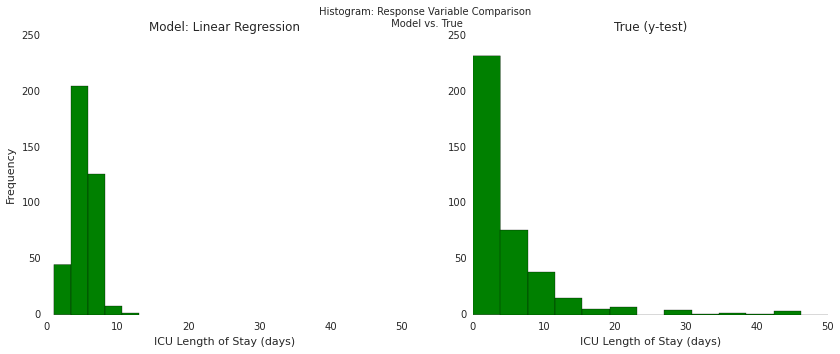

In [39]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred), bins=5, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [40]:
lr_rmse = RMSE(lr_pred, y_test)
print "RMSE = %.3f days" % lr_rmse

RMSE = 8.279 days


In [41]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.21,76.92]


The linear regression model has an RMSE value of 8.28 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [42]:
lr_mae = MAE(lr_pred, y_test)
print "MAE = %.3f days" % lr_mae

MAE = 3.135 days


The average difference between prediction and observation is 3.14 days, which is low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [43]:
lr_r2 = r2(lr_pred, y_test)
print "r2 = %.3f" % lr_r2

r2 = 0.002


The R<sup>2</sup> value is approximately 0.002, which indicates that the model does not have strong predictive power.

## Model: Support Vector Regression

In [28]:
def svr_gridsearch(X_train, X_test, y_train):
    """
    Function determines the optimal parameters of the best classifier model/estimator 
    by performing a grid search. The best model will be fitted with the Training set 
    and subsequently used to predict the classification/labels of the Testing set. 
    The function returns the "best" classifier instance, classifier predictions, 
    best params, and grid score.

    :param X_train: Training set features
    :param X_test: Testing set features
    :param y_train: Training set labels
    :return: tuple of (best classifier instance, clf predictions, dict of best params, grid score)
    """
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['linear']},
        {'C': [0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'kernel': ['rbf']}
#         {'C':[0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10], 'degree': [2], 'kernel': ['poly']}
    ]

    
    # Blank clf instance
    blank_clf = SVR()

    # Grid Search - Hyperparameters Optimization
    clf = grid_search.GridSearchCV(blank_clf, param_grid, n_jobs=-1)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)

    best_params = clf.best_params_  # best parameters identified by grid search
    score = clf.best_score_  # best grid score
    return (best_est, clf_pred, best_params, score)

In [91]:
svr_model, svr_pred, svr_p, svr_score = svr_gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", svr_p
print "Best Grid Search Score: ", svr_score
print "Best Estimator: ", svr_model, "\n"

Best Parameters:  {'kernel': 'rbf', 'C': 10, 'gamma': 10}
Best Grid Search Score:  -0.0211042940104
Best Estimator:  SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=10,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False) 



#### Compare Predictions

In [92]:
svr_pred[-10:]

array([ 4.06463828,  4.06463828,  4.06466803,  4.15710905,  4.06463828,
        3.8555837 ,  4.05960709,  4.06463828,  4.06463828,  4.06463828])

In [93]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   4.8671])

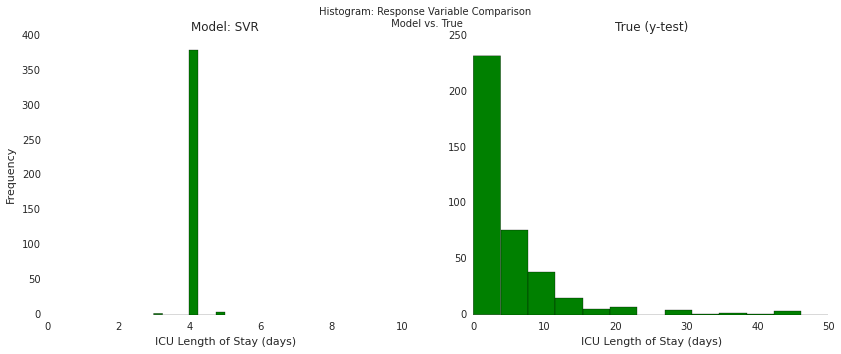

In [101]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred), bins=8, color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,10])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
# plt.ylim([0, 150])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [102]:
svr_rmse = RMSE(svr_pred, y_test)
print "RMSE = %.3f days" % svr_rmse

RMSE = 8.392 days


In [103]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.21,76.92]


The SVR model has an RMSE value of 8.4 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [104]:
svr_mae = MAE(svr_pred, y_test)
print "MAE = %.3f days" % svr_mae

MAE = 2.474 days


The average difference between prediction and observation is 2.47 days, which is relatively low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [105]:
r2(svr_pred, y_test)

-0.025668823297310572

The R<sup>2</sup> value is approximately -0.03, which is low and indicates that the model does not have strong predictive power. The negative (out of range) value also suggests that the model could be arbitrarily worse.

## Model: k-Nearest Neighbors

In [44]:
knn_model = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model.fit(scaled_X_train, y_train) # fit model on training data
knn_pred = knn_model.predict(scaled_X_test)

#### Compare Predictions

In [45]:
knn_pred[-10:]

array([ 1.49308,  3.25374,  5.7332 ,  3.55196,  3.64386,  1.6292 ,
        2.57974,  1.36588,  3.4398 ,  2.25012])

In [46]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   4.8671])

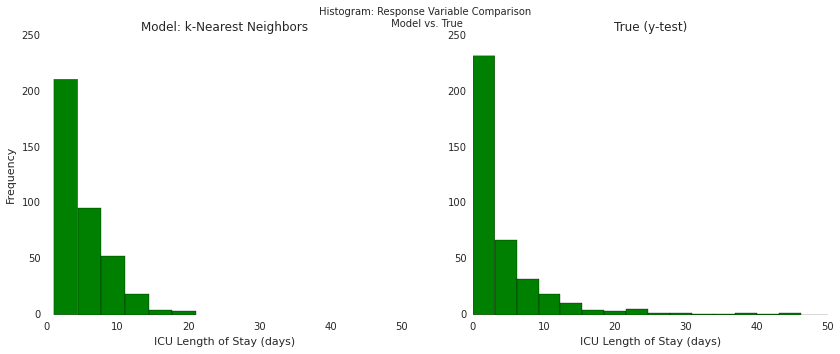

In [48]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred), bins=6, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [49]:
knn_rmse = RMSE(knn_pred, y_test)
print "RMSE = %.3f days" % knn_rmse

RMSE = 8.720 days


In [50]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.21,76.92]


The k-NN model has an RMSE value of 8.72 days. The value is somewhat small relative to the range of the `dependent variable` (average ICU LOS). Thus, indicating that model has decent accuracy in predicting the response.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [51]:
knn_mae = MAE(knn_pred, y_test)
print "MAE = %.3f days" % knn_mae

MAE = 2.735 days


The average difference between prediction and observation is 2.74 days, which is relatively low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [52]:
knn_r2 = r2(knn_pred, y_test)
print "r2 = %.2f" % knn_r2

r2 = -0.11


The k-NN model has poor predictive power. The negative R<sup>2</sup> is out of range, but possible as it indicates that the model can be arbitrarily worse. 

This may be attributed to the fact that it's a "lazy learning" algorithm, *lacking generalization*. The model only does work (build a model) at the time of prediction and uses minimal, if any Training data.

## Model: Random Forest

#### Criterion
  1. **mse**: mean squared error
  2. **mae**: mean absolute error

In [53]:
def rf_gridsearch(X_train, X_test, y_train):
    # Parameter Grid - dictionary of parameters (map parameter names to values to be searched)
    param_grid = [
        {'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
         'criterion': ['mse', 'mae']}
    ]

    rfr = RandomForestRegressor(random_state=2, n_jobs=-1)

    # Grid search to find "best" random forest classifier -- Hyperparameters Optimization
    clf = grid_search.GridSearchCV(rfr, param_grid)  # classifier + optimal parameters
    clf = clf.fit(X_train, y_train)  # fitted classifier -- Training Set
    best_est = clf.best_estimator_
    clf_pred = best_est.predict(X_test)  # apply classifier on test set for label predictions
    params = clf.best_params_  # optimal parameters
    score = clf.best_score_  # best grid score
    imp = best_est.feature_importances_
    return (best_est, clf_pred, params, score, imp)

In [54]:
rf_model, rf_pred, rf_p, rf_score, rf_imp = rf_gridsearch(scaled_X_train, scaled_X_test, y_train)
print "Best Parameters: ", rf_p
print "Best Grid Search Score: ", rf_score
print "Best Estimator: ", rf_model, "\n"

Best Parameters:  {'n_estimators': 10, 'criterion': 'mse'}
Best Grid Search Score:  -1.21682474787
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False) 



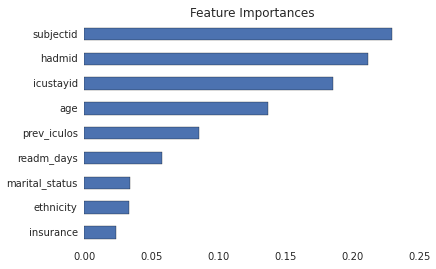

In [55]:
feats = data.drop('icu_los', axis=1)
feat_imp = pd.Series(rf_imp, 
                     index=feats.columns.values)
feat_imp.sort(inplace=True)
feat_imp.plot(kind='barh')
plt.title('Feature Importances')

#### Compare Predictions

In [56]:
rf_pred[-10:]

array([  2.77903,   5.30268,   6.76462,   8.37581,  13.2092 ,   8.03489,
         8.29919,   2.10448,  10.75695,   7.60514])

In [57]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   4.8671])

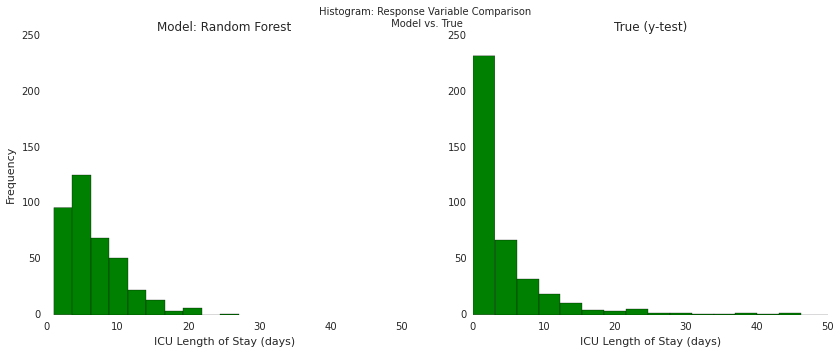

In [58]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred), bins=10, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=25, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

### Metrics

#### Root Mean Squared Error (RMSE)
Indicates the *absolute fit* of the model to the data. In other words, how close the observed data points are to the model's predicted values.

Also, it is the standard deviation of unexplained variance (residuals).

In [59]:
rf_rmse = RMSE(rf_pred, y_test)
print "RMSE = %.3f days" % rf_rmse

RMSE = 9.164 days


In [60]:
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())

[0.21,76.92]


The Random Forest regression model has an RMSE value of 9.16 days, which is relatively low compared to the response range.

#### Mean Absolute Error
The Mean Absolute Error measures how close the model's predictions are to the observed values.

In [61]:
rf_mae = MAE(rf_pred, y_test)
print "MAE = %.3f days" % rf_mae

MAE = 3.428 days


The average difference between prediction and observation is 3.43 days, which is relatively low.

#### R<sup>2</sup>: Coefficient of Determination
R<sup>2</sup> quantifies the goodness of fit of the linear model. More specifically, it depicts the predictive power of the model.

Range: [0, 1]

In [62]:
rf_r2 = r2(rf_pred, y_test)
print "r2 = %.2f" % rf_r2

r2 = -0.22


The Random Forest model has poor predictive power and could be arbitrarily worse as the R<sup>2</sup> score is out of range (negative).

## BoxCox Transformations

A BoxCox transformation is a normalization approach that is applicable to only continuous values. Features that are categorical or binary in nature are not appropriate due to the semantics of their numerical values.

**Note**: Box-Cox transformations can only handle positive values, non-positive values, including 0, are unapplicable.

In [29]:
scaled_X_train_boxcox = scaled_X_train.copy()
scaled_X_test_boxcox = scaled_X_test.copy()

# # inverse transform
orig_X_train_boxcox = scaler.inverse_transform(scaled_X_train_boxcox)
orig_X_test_boxcox = scaler.inverse_transform(scaled_X_test_boxcox)

# Box Cox Transformation
train_age_bc = stats.boxcox(orig_X_train_boxcox[:,5])[0]
test_age_bc = stats.boxcox(orig_X_test_boxcox[:,5])[0]

# Replace applicable features
scaled_X_train_boxcox[:,5] = train_age_bc
scaled_X_test_boxcox[:,5] = test_age_bc

### Model: Linear Regression

In [64]:
lr_model_bc, lr_pred_bc, lr_p_bc, lr_score_bc = lr_gridsearch(scaled_X_train_boxcox, scaled_X_test_boxcox, y_train)
print "Best Parameters: ", lr_p_bc
print "Best Grid Search Score: ", lr_score_bc
print "Best Estimator: ", lr_model_bc

Best Parameters:  {'normalize': True, 'fit_intercept': False}
Best Grid Search Score:  -0.0646630498647
Best Estimator:  LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)


#### Compare Predictions

In [65]:
lr_pred_bc[-10:]

array([  3.31055364,   6.92189101,   5.34893809,   6.32817637,
        12.63614691,   4.3545337 ,   6.43930395,   5.54138046,
         2.17930311,   5.0925694 ])

In [66]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   4.8671])

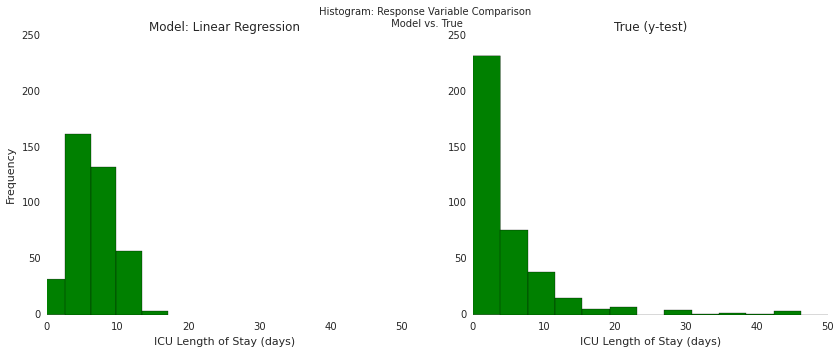

In [72]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(lr_pred_bc), bins=5, color='g')
plt.title("Model: Linear Regression")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

1. RMSE
2. MAE
3. R<sup>2</sup>

In [73]:
lr_rmse_bc = RMSE(lr_pred_bc, y_test)
print "RMSE = %.3f days" % lr_rmse_bc
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())
print6
lr_mae_bc = MAE(lr_pred_bc, y_test)
print "MAE = %.3f days" % lr_mae_bc
print
lr_r2_bc = r2(lr_pred_bc, y_test)
print "r2 = %.3f" % lr_r2_bc

RMSE = 8.559 days
[0.21,76.92]

MAE = 3.834 days

r2 = -0.067


The Linear Regression model with Box Cox transformation of applicable features has slightly worse metrics compared to its counterpart with standard scaling.

The RMSE and MAE increased by 0.3 and 0.7 days respectively. The values are still low, indicating small prediction errors. On the contrary, R<sup>2</sup> has decreased to a negative, out of range value of -0.07 suggesting that the model is now arbitrarily worse.

### Model: Support Vector Regression

In [30]:
svr_model_bc, svr_pred_bc, svr_p_bc, svr_score_bc = svr_gridsearch(scaled_X_train_boxcox, scaled_X_test_boxcox, y_train)
print "Best Parameters: ", svr_p_bc
print "Best Grid Search Score: ", svr_score_bc
print "Best Estimator: ", svr_model_bc

Best Parameters:  {'kernel': 'rbf', 'C': 10, 'gamma': 10}
Best Grid Search Score:  -0.0211842143187
Best Estimator:  SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=10,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


#### Compare Predictions

In [32]:
svr_pred_bc[-10:]

array([ 4.04806584,  4.04806584,  4.04806584,  4.04806584,  4.04806584,
        4.04806584,  4.04806584,  4.04806584,  4.04806584,  4.04806584])

In [33]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   4.8671])

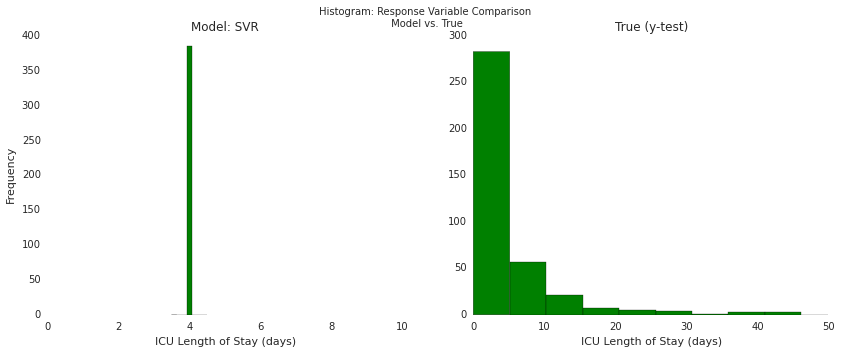

In [43]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(svr_pred_bc), bins=7, color='g')
plt.title("Model: SVR")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,10])
# plt.ylim([0, 120])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=15, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
# plt.ylim([0, 150])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

1. RMSE
2. MAE
3. R<sup>2</sup>

In [44]:
svr_rmse_bc = RMSE(svr_pred_bc, y_test)
print "RMSE = %.3f days" % svr_rmse_bc
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())
print
svr_mae_bc = MAE(svr_pred_bc, y_test)
print "MAE = %.3f days" % svr_mae_bc
print
svr_r2_bc = r2(svr_pred_bc, y_test)
print "r2 = %.3f" % svr_r2_bc

RMSE = 8.401 days
[0.21,76.92]

MAE = 2.466 days

r2 = -0.028


The Support Vector Regression model with Box Cox transformation of applicable features showed no improvements compared to its counterpart with standard scaling. No changes occured in the metrics RMSE, MAE, nor R<sup>2</sup>.

### Model: k-Nearest Neighbors

In [74]:
knn_model_bc = KNeighborsRegressor(n_neighbors=5, weights='uniform') # look at 5 closest neighbors
knn_model_bc.fit(scaled_X_train_boxcox, y_train) # fit model on training data
knn_pred_bc = knn_model_bc.predict(scaled_X_test_boxcox)

#### Compare Predictions

In [75]:
knn_pred_bc[-10:]

array([ 4.06686,  2.75604,  4.9453 ,  2.79302,  6.00906,  3.40238,
        2.25382,  8.60316,  4.61634,  3.21866])

In [76]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   4.8671])

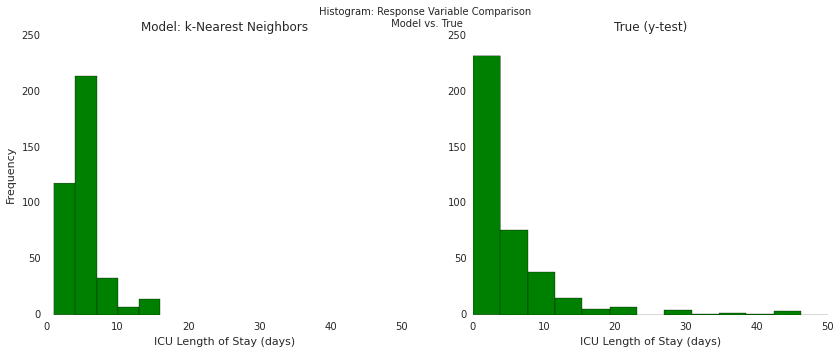

In [80]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(knn_pred_bc), bins=5, color='g')
plt.title("Model: k-Nearest Neighbors")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

1. RMSE
2. MAE
3. R<sup>2</sup>

In [81]:
knn_rmse_bc = RMSE(knn_pred_bc, y_test)
print "RMSE = %.3f days" % knn_rmse_bc
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())
print
knn_mae_bc = MAE(knn_pred_bc, y_test)
print "MAE = %.3f days" % knn_mae_bc
print
knn_r2_bc = r2(knn_pred_bc, y_test)
print "r2 = %.3f" % knn_r2_bc

RMSE = 8.791 days
[0.21,76.92]

MAE = 2.966 days

r2 = -0.126


The k-Nearest Neighbors model with Box Cox transformation of applicable features has slightly worse metrics compared to its counterpart with standard scaling.

The RMSE and MAE increased by 0.1 and 0.3 days respectively. The values are still low, indicating small prediction errors. The R<sup>2</sup> decreased by 0.02, suggesting that the model's predtive power got slightly worse.

### Model: Random Forest

In [82]:
rf_model_bc, rf_pred_bc, rf_p_bc, rf_score_bc, rf_imp_bc = rf_gridsearch(scaled_X_train_boxcox, scaled_X_test_boxcox, y_train)
print "Best Parameters: ", rf_p_bc
print "Best Grid Search Score: ", rf_score_bc
print "Best Estimator: ", rf_model_bc

Best Parameters:  {'n_estimators': 10, 'criterion': 'mse'}
Best Grid Search Score:  -1.21606699362
Best Estimator:  RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)


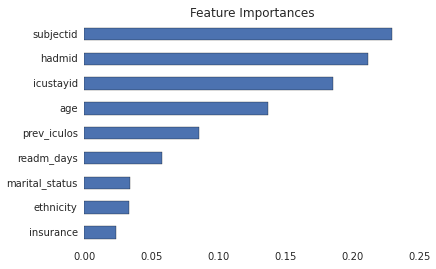

In [83]:
# feats = data.drop('icu_los', axis=1)
feat_imp_bc = pd.Series(rf_imp_bc, 
                     index=feats.columns.values)
feat_imp_bc.sort(inplace=True)
feat_imp_bc.plot(kind='barh')
plt.title('Feature Importances')

#### Compare Predictions

In [84]:
rf_pred_bc[-10:]

array([  3.11498,  10.26594,   4.62444,   7.7706 ,  10.23747,   9.96622,
         8.09266,   4.63674,  10.75695,   7.70208])

In [85]:
y_test[-10:]

array([ 11.6744,   9.2824,  21.8131,  11.6055,   4.5255,   4.0701,
         1.1331,   2.7381,   0.6534,   4.8671])

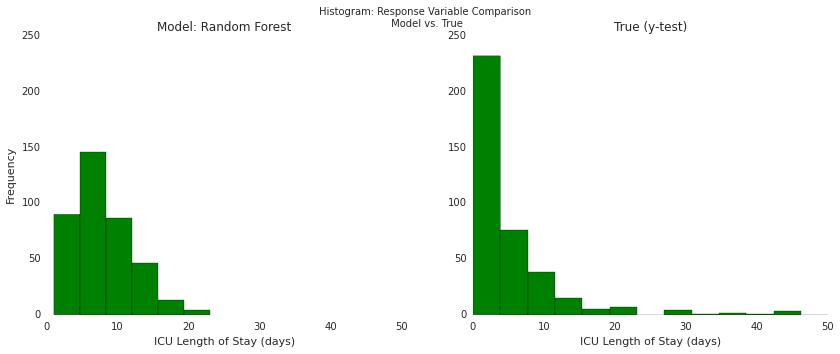

In [113]:
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.hist(np.round(rf_pred_bc), bins=6, color='g')
plt.title("Model: Random Forest")
plt.xlabel('ICU Length of Stay (days)')
plt.ylabel('Frequency')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(np.round(y_test), bins=20, color='g')
plt.title("True (y-test)")
plt.xlabel('ICU Length of Stay (days)')
plt.xlim([0,50])
plt.ylim([0, 250])
plt.legend(loc='upper right')
plt.suptitle('Histogram: Response Variable Comparison \n Model vs. True')

plt.show()

#### Metrics

1. RMSE
2. MAE
3. R<sup>2</sup>

In [114]:
rf_rmse_bc = RMSE(rf_pred_bc, y_test)
print "RMSE = %.3f days" % rf_rmse_bc
print "[%.2f,%.2f]" % (y_test.min(), y_test.max())
print
rf_mae_bc = MAE(rf_pred_bc, y_test)
print "MAE = %.3f days" % rf_mae_bc
print
rf_r2_bc = r2(rf_pred_bc, y_test)
print "r2 = %.3f" % rf_r2_bc

RMSE = 9.095 days
[0.21,76.92]

MAE = 4.571 days

r2 = -0.205


The Random Forest Regression model with Box Cox transformation of applicable features has mixed results in terms of improvement compared to its counterpart with standard scaling.

The RMSE and MAE decreased by 0.1 and increased by 1.2 days respectively. The model is slightly improved at predicting large errors, but it's at a tradeoff of increasing it's average absolute error of prediction by about a day.

The R<sup>2</sup> decreased by 0.01, suggesting that the model's predtive power got slightly better, but is still very poor.

## Conclusion
Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.3|3.1|0.002
Support Vector Regression (*kernel: rbf*)|8.4|2.5|-0.03
k-Nearest Neighbors|8.7|2.7|-0.11
Random Forest|9.2|3.4|-0.22

All regression models have roughly similar metrics. They all have low predictive errors with relatively low RMSE and MAE values. On the contrary, they all have very poor R<sup>2</sup> scores, demonstrating poor predictive power.

#### RMSE
In regards to RMSE, the models have relatively decent performances in the prediction of ICU length of stay for new, unseen data. The RMSE values are greater than the MAE values for all models, suggesting that there are a higher frequency of larger residuals as the metric penalizes bigger discrepancies.

#### MAE
All models are proficient in terms of their mean absolute errors with values ranging from 2-4 days for the ICU length of stays. Essentially, the models are only off, on average, 3 days in their prediction.

#### R<sup>2</sup> - Coefficient of Determination
The very low R<sup>2</sup> values indicate that the models have very poor predictive power. All models, except for Linear Regression have negative, out of range R<sup>2</sup> scores, suggesting that they are arbitrarily worse or ungeneralizable to new data.

More specifically, the k-Nearest Neighbors model is a weak model. Its poor generalizability is possibly attributed to the fact that it's approach is "lazy learning". The model does not encompass a training phase and instead holds the entire training data and builds its model at the time of prediction. A drawback of this approach is longer run-time.

### Box Cox Transformation
Box Cox transformation was performed on only the following feature(s): `ages`. These feature(s) are the only one(s) that have positive values and are continuous. Other unapplicable features either had non-positive values or were categorical in nature.

Model | RMSE | MAE | R<sup>2</sup> |
:-----|:----:|:---:| :------------:|
Linear Regression|8.6|3.8|-0.07
Support Vector Regression (*kernel: rbf*)|8.4|2.5|-0.03
k-Nearest Neighbors|8.8|3.0|-0.13
Random Forest|9.1|4.6|-0.21

This normalization approach gave no improvements to the model. All metrics indicate that the transformation actually slightly worsened, if not yielded the same results as the models' "standard scaling" counterparts. 

Thus, it's conluded that the transformation is not appropriate for this dataset.